In [ ]:
import torch
from torch.utils.data import Dataset
import statistics

class PatientDataset(Dataset):
    """
    A PyTorch Dataset that creates a prompt for clinical outcome prediction
    from raw patient data. The prompt includes summarized clinical details,
    key treatment events, and aggregated lab test values. The prediction target
    is the outcome (e.g., Overall Survival Status and Overall Survival in Months).
    """
    def __init__(self, patient_data_list):
        """
        patient_data_list: a list of dictionaries (one per patient) containing keys:
           - "clinical_data"
           - "demographic"
           - "treatment"
           - "lab_test"
           (Other sections can be added if needed.)
        """
        self.patient_data_list = patient_data_list

    def __len__(self):
        return len(self.patient_data_list)

    def summarize_clinical_data(self, clinical_data):
        """Extract key clinical fields (e.g., survival status, age, stage)"""
        summary = {}
        for entry in clinical_data:
            attr = entry.get("Attribute", "").lower()
            val = entry.get("Value", "")
            if "overall survival status" in attr:
                summary["survival_status"] = val
            elif "current age" in attr:
                summary["age"] = val
            elif "stage" in attr:
                summary["stage"] = val
            elif "overall survival (months)" in attr:
                summary["survival_months"] = val
            # add more clinical fields as needed...
        return summary

    def summarize_treatment(self, treatment_data):
        """Summarize treatment events: count by subtype and list unique agents"""
        treatment_summary = {"Chemo": [], "Immuno": [], "Investigational": [], "Radiation": []}
        for entry in treatment_data:
            subtype = entry.get("SUBTYPE", "")
            agent = entry.get("AGENT", "")
            if "chemo" in subtype.lower():
                treatment_summary["Chemo"].append(agent)
            elif "immuno" in subtype.lower():
                treatment_summary["Immuno"].append(agent)
            elif "investigational" in subtype.lower():
                treatment_summary["Investigational"].append(agent)
            elif "radiation" in subtype.lower():
                treatment_summary["Radiation"].append(agent)
        # Remove duplicates and count events
        for key in treatment_summary:
            treatment_summary[key] = {
                "count": len(treatment_summary[key]),
                "agents": list(set(treatment_summary[key]))
            }
        return treatment_summary

    def summarize_lab_tests(self, lab_tests):
        """
        Summarize lab tests by computing the average of the last reported values
        for key tests (e.g., CEA and CA_15-3). In practice, you could also
        compute trends, but here we take the average.
        """
        cea_values = []
        ca15_3_values = []
        for test in lab_tests:
            test_name = test.get("TEST", "").upper()
            try:
                result = float(test.get("RESULT", 0))
            except ValueError:
                continue
            if test_name == "CEA":
                cea_values.append(result)
            elif test_name == "CA_15-3":
                ca15_3_values.append(result)
        lab_summary = {}
        if cea_values:
            lab_summary["CEA_avg"] = round(statistics.mean(cea_values), 2)
        if ca15_3_values:
            lab_summary["CA15-3_avg"] = round(statistics.mean(ca15_3_values), 2)
        return lab_summary

    def create_prompt(self, patient):
        """
        Create a prompt string summarizing the key patient data.
        Only include sections that directly impact prediction.
        """
        clinical_summary = self.summarize_clinical_data(patient.get("clinical_data", []))
        treatment_summary = self.summarize_treatment(patient.get("treatment", []))
        lab_summary = self.summarize_lab_tests(patient.get("lab_test", []))
        
        # Construct narrative for clinical details
        clinical_narrative = (
            f"Patient is {clinical_summary.get('age', 'unknown')} years old, with "
            f"stage {clinical_summary.get('stage', 'unknown')} disease. "
            f"Overall survival status is {clinical_summary.get('survival_status', 'unknown')}, "
            f"with an overall survival of {clinical_summary.get('survival_months', 'unknown')} months."
        )
        
        # Construct narrative for treatment details
        treatment_narrative = "Treatment summary: "
        for key, val in treatment_summary.items():
            if val["count"] > 0:
                treatment_narrative += f"{key}: {val['count']} event(s) using agents {', '.join(val['agents'])}. "
        
        # Construct narrative for lab tests
        lab_narrative = "Lab test summary: "
        if lab_summary:
            lab_narrative += ", ".join([f"{k}: {v}" for k, v in lab_summary.items()])
        else:
            lab_narrative += "No lab test data available."
        
        # Final prompt structure
        prompt = (
            "You are a clinical outcome prediction model. Based on the following patient summary, "
            "predict the clinical treatment outcome. \n\n"
            "Clinical Details:\n"
            f"{clinical_narrative}\n\n"
            "Treatment Details:\n"
            f"{treatment_narrative}\n\n"
            "Lab Test Summary:\n"
            f"{lab_narrative}\n\n"
            "Please provide your prediction with the following format:\n"
            "- Predicted Outcome (e.g., '0:LIVING' or other status)\n"
            "- Estimated Overall Survival (Months)\n"
            "- Key Influencing Factors (brief explanation)\n"
        )
        return prompt

    def get_prediction_target(self, patient):
        """
        Extract the prediction target from the patient data.
        In this example, we use the Overall Survival Status and Overall Survival (Months).
        """
        clinical_summary = self.summarize_clinical_data(patient.get("clinical_data", []))
        target = {
            "survival_status": clinical_summary.get("survival_status", "unknown"),
            "survival_months": clinical_summary.get("survival_months", "unknown")
        }
        return target

    def __getitem__(self, idx):
        patient = self.patient_data_list[idx]
        prompt = self.create_prompt(patient)
        prediction = self.get_prediction_target(patient)
        return {"prompt": prompt, "prediction": prediction}


# Example usage:
if __name__ == "__main__":
    # Example raw patient data (normally loaded from your dataset)
    patient_data = [{
        "clinical_data": [
            {"Attribute": "Overall Survival Status", "Value": "0:LIVING"},
            {"Attribute": "Current Age", "Value": "68"},
            {"Attribute": "Stage (Highest Recorded)", "Value": "Stage 1-3"},
            {"Attribute": "Overall Survival (Months)", "Value": "118.5"}
        ],
        "treatment": [
            {"START_DATE": "33", "STOP_DATE": "40", "EVENT_TYPE": "Treatment", "SUBTYPE": "Chemo", "AGENT": "CISPLATIN"},
            {"START_DATE": "33", "STOP_DATE": "65", "EVENT_TYPE": "Treatment", "SUBTYPE": "Chemo", "AGENT": "ETOPOSIDE"},
            {"START_DATE": "1734", "STOP_DATE": "1814", "EVENT_TYPE": "Treatment", "SUBTYPE": "Immuno", "AGENT": "NIVOLUMAB"}
        ],
        "lab_test": [
            {"TEST": "CEA", "RESULT": "2.9"},
            {"TEST": "CEA", "RESULT": "3.2"},
            {"TEST": "CA_15-3", "RESULT": "10"},
            {"TEST": "CA_15-3", "RESULT": "13"}
        ]
    }]

    dataset = PatientDataset(patient_data)
    sample = dataset[0]
    print("Prompt:\n", sample["prompt"])
    print("Prediction Target:\n", sample["prediction"])


In [ ]:
import torch
from torch.utils.data import Dataset

class TreatmentOutcomeDataset(Dataset):
    def __init__(self, patient_records, tokenizer=None):
        """
        patient_records: List[dict]
            Each dictionary should contain patient data with keys such as:
            "clinical_data", "treatment", "therapy", and optionally "demographic".
        
        tokenizer: Optional tokenizer to encode the prompt if needed.
        """
        self.patient_records = patient_records
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.patient_records)

    def _extract_summary(self, record):
        # Extract clinical data summary
        clinical = record.get("clinical_data", [])
        survival_status = next((item["Value"] for item in clinical if item["Attribute"] == "Overall Survival Status"), "N/A")
        survival_months = next((item["Value"] for item in clinical if item["Attribute"] == "Overall Survival (Months)"), "N/A")
        stage = next((item["Value"] for item in clinical if item["Attribute"] == "Stage (Highest Recorded)"), "N/A")
        age = next((item["Value"] for item in clinical if item["Attribute"] == "Current Age"), "N/A")
        smoking = next((item["Value"] for item in clinical if item["Attribute"] == "Smoking History (NLP)"), "N/A")
        
        # Extract tumor sites from clinical_data (narrative summary)
        tumor_sites = []
        for item in clinical:
            if "Tumor Site:" in item["Attribute"]:
                # Only include if Value indicates a positive finding (e.g., Yes/True or count > 0)
                if item["Value"].lower() in ["yes", "true"]:
                    site = item["Attribute"].split("Tumor Site:")[-1].strip()
                    tumor_sites.append(site)
        tumor_sites_summary = ", ".join(tumor_sites) if tumor_sites else "None"

        # Summarize treatment events
        treatments = record.get("treatment", [])
        chemo_events = []
        immuno_events = []
        investigational_events = []
        for t in treatments:
            subtype = t.get("SUBTYPE", "").lower()
            agent = t.get("AGENT", "")
            start = t.get("START_DATE", "")
            stop = t.get("STOP_DATE", "")
            if subtype == "chemo":
                chemo_events.append(f"{agent} ({start} to {stop})")
            elif subtype == "immuno":
                immuno_events.append(f"{agent} ({start} to {stop})")
            elif subtype == "investigational":
                investigational_events.append(f"{agent} ({start} to {stop})")
        chemo_summary = "; ".join(chemo_events) if chemo_events else "None"
        immuno_summary = "; ".join(immuno_events) if immuno_events else "None"
        investigational_summary = "; ".join(investigational_events) if investigational_events else "None"

        # Summarize radiation therapy from therapy section (if available)
        therapy = record.get("therapy", [])
        radiation_events = [f"{t.get('SUBTYPE', '')} starting {t.get('START_DATE', '')}" 
                            for t in therapy if "Radiation" in t.get("SUBTYPE", "")]
        radiation_summary = "; ".join(radiation_events) if radiation_events else "None"

        # Optionally, include brief demographic context
        demographic = record.get("demographic", [])
        cancer_type = "N/A"
        clinical_group = "N/A"
        primary_site = "N/A"
        for item in demographic:
            if item.get("Attribute") == "Cancer Type":
                # Select one value from the dictionary values (excluding the 'Attribute' key)
                for key, value in item.items():
                    if key != "Attribute":
                        cancer_type = value
                        break
            if item.get("Attribute") == "Clinical Group":
                for key, value in item.items():
                    if key != "Attribute":
                        clinical_group = value
                        break
            if item.get("Attribute") == "Primary Tumor Site":
                for key, value in item.items():
                    if key != "Attribute":
                        primary_site = value
                        break

        # Construct a brief narrative summary
        summary = (
            f"Overall Survival Status: {survival_status}. "
            f"Overall Survival (Months): {survival_months}. "
            f"Stage: {stage}. "
            f"Age: {age}. Smoking History: {smoking}. "
            f"Tumor Sites: {tumor_sites_summary}. "
            f"Chemotherapy: {chemo_summary}. "
            f"Immunotherapy: {immuno_summary}. "
            f"Investigational Treatments: {investigational_summary}. "
            f"Radiation Therapy: {radiation_summary}. "
            f"Cancer Type: {cancer_type}. Clinical Group: {clinical_group}. "
            f"Primary Tumor Site: {primary_site}."
        )
        return summary, survival_status, survival_months

    def _build_prompt(self, record):
        summary, survival_status, survival_months = self._extract_summary(record)
        prompt = (
            "You are a clinical outcome prediction model. Based on the patient data below, "
            "predict the clinical treatment outcome. Focus on the provided key factors including survival status, "
            "disease stage, tumor sites, patient age, smoking history, and treatment details.\n\n"
            "Patient Data Summary:\n"
            f"{summary}\n\n"
            "Please provide your prediction in the following format:\n"
            "- Predicted Outcome (e.g., Overall Survival Status)\n"
            "- Estimated Overall Survival (Months)\n"
            "- Key Influencing Factors and a Brief Explanation."
        )
        # If needed, apply tokenizer encoding here:
        if self.tokenizer:
            encoded = self.tokenizer(prompt, truncation=True, max_length=4068)
            prompt = encoded.input_ids  # Or whatever your training process expects.
        return prompt, {"survival_status": survival_status, "survival_months": survival_months}

    def __getitem__(self, idx):
        record = self.patient_records[idx]
        prompt, target = self._build_prompt(record)
        return {"prompt": prompt, "target": target}

# Example usage:
if __name__ == "__main__":
    # Suppose 'data' is a list of patient records (dictionaries)
    data = [
        {
            "clinical_data": [
                {"Attribute": "Overall Survival Status", "Value": "0:LIVING"},
                {"Attribute": "Overall Survival (Months)", "Value": "118.5"},
                {"Attribute": "Stage (Highest Recorded)", "Value": "Stage 1-3"},
                {"Attribute": "Current Age", "Value": "68"},
                {"Attribute": "Smoking History (NLP)", "Value": "Former/Current Smoker"},
                {"Attribute": "Tumor Site: Intra Abdominal", "Value": "Yes"},
                {"Attribute": "Tumor Site: Lung (NLP)", "Value": "Yes"},
                {"Attribute": "Tumor Site: Lymph Node (NLP)", "Value": "Yes"},
                {"Attribute": "Tumor Site: Other (NLP)", "Value": "Yes"}
            ],
            "treatment": [
                {"START_DATE": "-5437", "STOP_DATE": "-5369", "EVENT_TYPE": "Treatment", "SUBTYPE": "Chemo", "AGENT": "CYCLOPHOSPHAMIDE"},
                {"START_DATE": "-5437", "STOP_DATE": "-5326", "EVENT_TYPE": "Treatment", "SUBTYPE": "Chemo", "AGENT": "FLUOROURACIL"},
                {"START_DATE": "33", "STOP_DATE": "40", "EVENT_TYPE": "Treatment", "SUBTYPE": "Chemo", "AGENT": "CISPLATIN"},
                {"START_DATE": "33", "STOP_DATE": "65", "EVENT_TYPE": "Treatment", "SUBTYPE": "Chemo", "AGENT": "ETOPOSIDE"},
                {"START_DATE": "61", "STOP_DATE": "68", "EVENT_TYPE": "Treatment", "SUBTYPE": "Chemo", "AGENT": "CARBOPLATIN"},
                {"START_DATE": "1734", "STOP_DATE": "1814", "EVENT_TYPE": "Treatment", "SUBTYPE": "Immuno", "AGENT": "NIVOLUMAB"}
            ],
            "therapy": [
                {"START_DATE": "33", "STOP_DATE": "", "EVENT_TYPE": "TREATMENT", "SUBTYPE": "Radiation Therapy"}
            ],
            "demographic": [
                {"Attribute": "Cancer Type", "P-0000012-T03-IM3": "Non-Small Cell Lung Cancer"},
                {"Attribute": "Clinical Group", "P-0000012-T03-IM3": "3B"},
                {"Attribute": "Primary Tumor Site", "P-0000012-T03-IM3": "Lung"}
            ]
        }
    ]
    
    dataset = TreatmentOutcomeDataset(data)
    sample = dataset[0]
    print("Prompt:")
    print(sample["prompt"])
    print("\nTarget:")
    print(sample["target"])


In [1]:
import json
import torch
from torch.utils.data import Dataset

class TreatmentOutcomeDataset(Dataset):
    def __init__(self, json_files, tokenizer=None):
        """
        json_file: Path to the JSON file containing a list of patient records.
        tokenizer: Optional tokenizer to encode the prompt if needed.
        """
        self.patient_records = []
        for json_file in json_files:
            patient_id = json_file.split("/")[-1].split(".")[0]
            with open(json_file, "r") as f:
                self.patient_records.append((json.load(f), patient_id))
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.patient_records)

    def _extract_summary(self, record):
        # Extract clinical data summary
        clinical = record.get("clinical_data", [])
        survival_status = next((item["Value"] for item in clinical if item["Attribute"] == "Overall Survival Status"), "N/A")
        survival_months = next((item["Value"] for item in clinical if item["Attribute"] == "Overall Survival (Months)"), "N/A")
        stage = next((item["Value"] for item in clinical if item["Attribute"] == "Stage (Highest Recorded)"), "N/A")
        stage = stage.replace("(NLP)", "").strip()  # Remove NLP suffix if present
        age = next((item["Value"] for item in clinical if item["Attribute"] == "Current Age"), "N/A")
        age = age.replace("(NLP)", "").strip()
        smoking = next((item["Value"] for item in clinical if item["Attribute"] == "Smoking History (NLP)"), "N/A")
        smoking = smoking.replace("(NLP)", "").strip()
        
        # Extract tumor sites from clinical_data (narrative summary)
        tumor_sites = []
        for item in clinical:
            if "Tumor Site:" in item["Attribute"]:
                # Only include if Value indicates a positive finding (e.g., Yes/True)
                if item["Value"].lower() in ["yes", "true"]:
                    site = item["Attribute"].split("Tumor Site:")[-1].strip()
                    site = site.replace("(NLP)", "").strip()  # Remove NLP suffix if present
                    tumor_sites.append(site)
        tumor_sites_summary = ", ".join(tumor_sites) if tumor_sites else "None"


        # Summarize treatment events
        treatments = record.get("treatment", [])
        chemo_events = []
        immuno_events = []
        investigational_events = []
        for t in treatments:
            subtype = t.get("SUBTYPE", "").lower()
            agent = t.get("AGENT", "")
            agent = agent.replace("(NLP)", "").strip()  # Remove NLP suffix if present
            start = t.get("START_DATE", "")
            stop = t.get("STOP_DATE", "")
            if subtype == "chemo":
                chemo_events.append(f"{agent} ({start} to {stop})")
            elif subtype == "immuno":
                immuno_events.append(f"{agent} ({start} to {stop})")
            elif subtype == "investigational":
                investigational_events.append(f"{agent} ({start} to {stop})")
        chemo_summary = "; ".join(chemo_events) if chemo_events else "None"
        immuno_summary = "; ".join(immuno_events) if immuno_events else "None"
        investigational_summary = "; ".join(investigational_events) if investigational_events else "None"

        # Summarize radiation therapy from therapy section (if available)
        therapy = record.get("therapy", [])
        radiation_events = [f"{t.get('SUBTYPE', '')} starting {t.get('START_DATE', '')}" 
                            for t in therapy if "Radiation" in t.get("SUBTYPE", "")]
        radiation_summary = "; ".join(radiation_events) if radiation_events else "None"
        radiation_summary = radiation_summary.replace("(NLP)", "").strip()  # Remove NLP suffix if present

        # Optionally, include brief demographic context
        demographic = record.get("demographic", [])
        cancer_type = "N/A"
        clinical_group = "N/A"
        primary_site = "N/A"
        for item in demographic:
            if item.get("Attribute") == "Cancer Type":
                for key, value in item.items():
                    if key != "Attribute":
                        cancer_type = value
                        cancer_type = cancer_type.replace("(NLP)", "").strip()  # Remove NLP suffix if present
                        break
            if item.get("Attribute") == "Clinical Group":
                for key, value in item.items():
                    if key != "Attribute":
                        clinical_group = value
                        clinical_group = clinical_group.replace("(NLP)", "").strip()  # Remove NLP suffix if present
                        break
            if item.get("Attribute") == "Primary Tumor Site":
                for key, value in item.items():
                    if key != "Attribute":
                        primary_site = value
                        primary_site = primary_site.replace("(NLP)", "").strip()  # Remove NLP suffix if present
                        break

        # Construct a brief narrative summary
        summary = (
            f"Stage: {stage}.\n"
            f"Age: {age}. Smoking History: {smoking}.\n"
            f"Tumor Sites: {tumor_sites_summary}.\n"
            f"Chemotherapy: {chemo_summary}.\n"
            f"Immunotherapy: {immuno_summary}.\n"
            f"Investigational Treatments: {investigational_summary}.\n"
            f"Radiation Therapy: {radiation_summary}.\n"
            f"Cancer Type: {cancer_type}. Clinical Group: {clinical_group}.\n"
            f"Primary Tumor Site: {primary_site}.\n"
        )
        return summary, survival_status, survival_months

    def _build_prompt(self, record):
        summary, survival_status, survival_months = self._extract_summary(record)
        prompt = (
            "You are a cancer clinical outcome prediction model. Based on the patient data below, "
            "predict the cancer clinical treatment outcome. Focus on the provided key factors including "
            "disease stage, tumor sites, patient age, smoking history, cancer type, and treatment details.\n\n"
            "Patient Data Summary:\n"
            f"{summary}\n\n"
            "Please provide your prediction in the following format:\n"
            "- Overall Survival Status ('0:LIVING' or '1:DECEASED')\n"
            "- Estimated Overall Survival in Months (float value)\n"
        )
        # If needed, apply tokenizer encoding here:
        if self.tokenizer:
            encoded = self.tokenizer(prompt, truncation=True, max_length=4068)
            prompt = encoded.input_ids  # Adjust based on your tokenizer and training process.
        return summary, survival_status, survival_months

    def __getitem__(self, idx):
        record, patient_id = self.patient_records[idx]
        summary, survival_status, survival_months = self._build_prompt(record)
        return {"patient_data": summary, "survival_status": survival_status, "survival_months": survival_months, "patient_id": patient_id}


In [ ]:
from glob import glob
import json

json_file_list = glob("patient_data/*.json") 
dataset = TreatmentOutcomeDataset(json_file_list)

# Save the dataset prompts and targets as a JSON file
output_data = []
for i in range(len(dataset)):
    sample = dataset[i]
    output_data.append(sample)

# with open("prompt_data.json", "w") as f:
#     json.dump(output_data, f, indent=4)

print("Dataset saved to prompt_data.json")


Dataset saved to prompt_data.json


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import os

hugging_face_token = os.getenv("HUGGING_FACE_TOKEN")
# Load the LLaMA tokenizer
model_name = "meta-llama/Llama-3.1-8B"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, token = hugging_face_token)
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Maximum token count: 574
Sum of token counts: 2465627


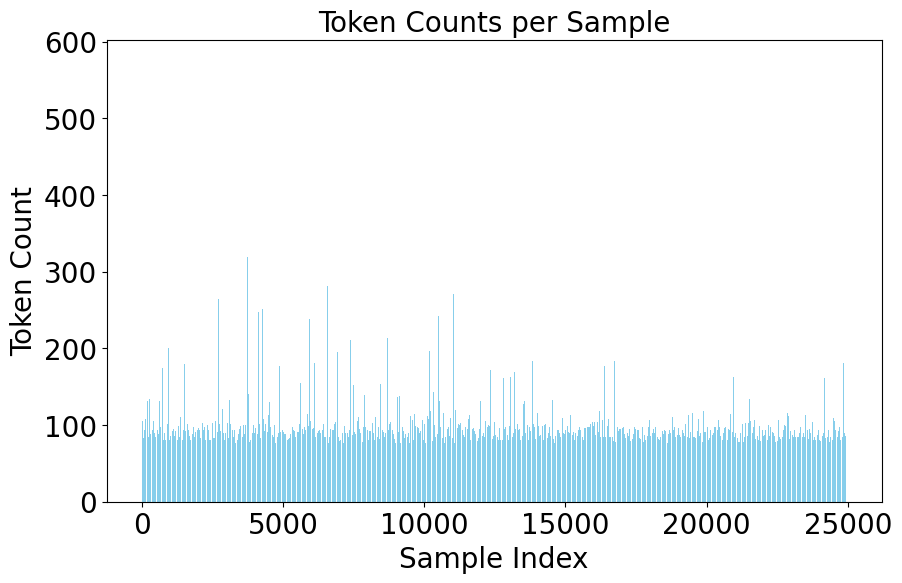

In [4]:
# Iterate through the dataset and calculate token count for each row
token_counts = []
for i in range(len(dataset)):
    sample = dataset[i]
    prompt = sample["patient_data"] + str(sample["survival_status"]) + str(sample["survival_months"])  # Combining "patient_data" and "status" for the prompt
    if isinstance(prompt, list):  # If already tokenized
        token_count = len(prompt)
    else:  # Tokenize the prompt
        tokenized = tokenizer(prompt)
        token_count = len(tokenized["input_ids"])
    token_counts.append({"index": i, "token_count": token_count})

# Get the maximum token count
max_token_count = max([entry["token_count"] for entry in token_counts])
print(f"Maximum token count: {max_token_count}")
print(f"Sum of token counts: {sum([entry['token_count'] for entry in token_counts])}")
import matplotlib.pyplot as plt

# Extract token counts for plotting
indices = [entry["index"] for entry in token_counts]
counts = [entry["token_count"] for entry in token_counts]

# Plot the token counts with increased font sizes
plt.figure(figsize=(10, 6))
plt.bar(indices, counts, color='skyblue')
plt.xlabel('Sample Index', fontsize=20)
plt.ylabel('Token Count', fontsize=20)
plt.title('Token Counts per Sample', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

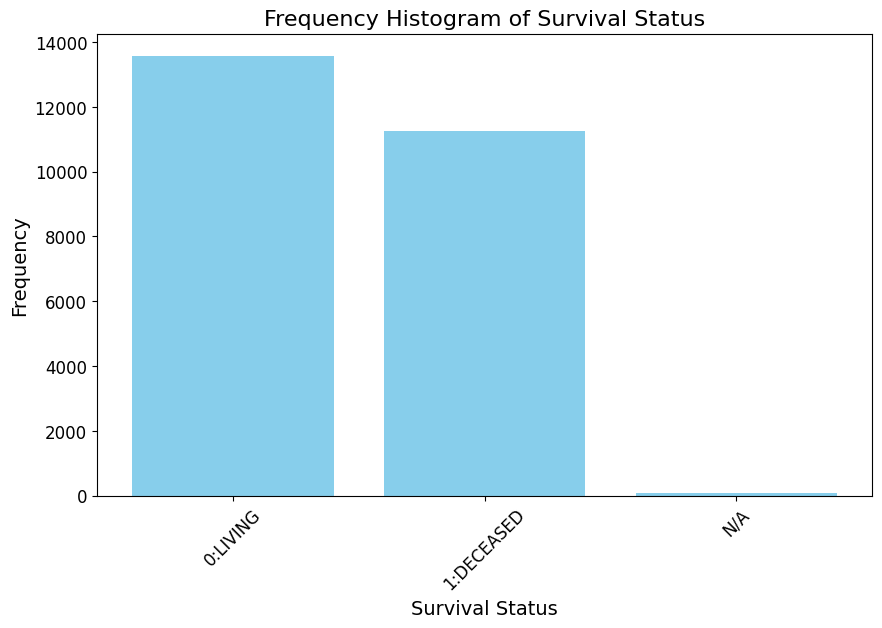

In [6]:
from collections import Counter

import matplotlib.pyplot as plt

# Extract survival_status values from the output_data
survival_statuses = [entry['survival_status'] for entry in output_data]

# Count the frequency of each survival_status
status_counts = Counter(survival_statuses)

# Plot the frequency histogram
plt.figure(figsize=(10, 6))
plt.bar(status_counts.keys(), status_counts.values(), color='skyblue')
plt.xlabel('Survival Status', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Frequency Histogram of Survival Status', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
import random

# Filter samples with token count > 150
filtered_samples = [entry for entry, token_entry in zip(output_data, token_counts) if token_entry["token_count"] > 150]

# Separate samples by survival_status
living_samples = [sample for sample in filtered_samples if sample["survival_status"] == "0:LIVING"]
deceased_samples = [sample for sample in filtered_samples if sample["survival_status"] == "1:DECEASED"]

# Select 5,000 samples from each category
selected_living = living_samples[:5000]
selected_deceased = deceased_samples[:5000]

# Ensure reproducibility
random.seed(42)

# Take the remaining samples from output_data that are not in filtered_samples
remaining_samples = [sample for sample in output_data if sample not in filtered_samples]

# Randomly sample additional data if needed
if len(selected_living) < 5000:
    additional_living = random.sample(
        [sample for sample in remaining_samples if sample["survival_status"] == "0:LIVING"],
        5000 - len(selected_living)
    )
    selected_living.extend(additional_living)

if len(selected_deceased) < 5000:
    additional_deceased = random.sample(
        [sample for sample in remaining_samples if sample["survival_status"] == "1:DECEASED"],
        5000 - len(selected_deceased)
    )
    selected_deceased.extend(additional_deceased)

# Combine the selected samples into a new dataset
new_dataset = selected_living + selected_deceased

# Verify the size of the new dataset
print(f"New dataset size: {len(new_dataset)}")
print(f"0:LIVING samples: {len(selected_living)}")
print(f"1:DECEASED samples: {len(selected_deceased)}")

# Save the combined dataset as a JSON file
with open("cot_data.json", "w") as f:
    json.dump(new_dataset, f, indent=4)

print("Combined dataset saved to cot_data.json")

New dataset size: 10000
0:LIVING samples: 5000
1:DECEASED samples: 5000
Combined dataset saved to cot_data.json


In [4]:
import random
import json

with open("cot_data.json", "r") as f:
    current_cot_data_json = json.load(f)

with open("prompt_data.json", "r") as f:
    all_data = json.load(f)

current_cot_data = set()
for cot_data in current_cot_data_json:
    patient_id = cot_data.get("patient_id")
    if patient_id:
        current_cot_data.add(patient_id)

# Filter samples with token count > 150
# filtered_samples = [entry for entry, token_entry in zip(all_data, token_counts) if token_entry["token_count"] > 150]
filtered_samples = all_data

# Separate samples by survival_status
living_samples = [sample for sample in filtered_samples if sample["survival_status"] == "0:LIVING" and sample["patient_id"] not in current_cot_data]
deceased_samples = [sample for sample in filtered_samples if sample["survival_status"] == "1:DECEASED" and sample["patient_id"] not in current_cot_data]

# Select 5,000 samples from each category
selected_living = living_samples[:5000]
selected_deceased = deceased_samples[:5000]

# Ensure reproducibility
random.seed(42)

# Take the remaining samples from output_data that are not in filtered_samples
remaining_samples = [sample for sample in all_data if sample not in filtered_samples and sample["patient_id"] not in current_cot_data]

# Randomly sample additional data if needed
if len(selected_living) < 5000:
    additional_living = random.sample(
        [sample for sample in remaining_samples if sample["survival_status"] == "0:LIVING"],
        5000 - len(selected_living)
    )
    selected_living.extend(additional_living)

if len(selected_deceased) < 5000:
    additional_deceased = random.sample(
        [sample for sample in remaining_samples if sample["survival_status"] == "1:DECEASED"],
        5000 - len(selected_deceased)
    )
    selected_deceased.extend(additional_deceased)

# Combine the selected samples into a new dataset
new_dataset = []
for living, deceased in zip(selected_living, selected_deceased):
    new_dataset.append(living)
    new_dataset.append(deceased)

# Verify the size of the new dataset
print(f"New dataset size: {len(new_dataset)}")
print(f"0:LIVING samples: {len(selected_living)}")
print(f"1:DECEASED samples: {len(selected_deceased)}")

# Save the combined dataset as a JSON file
with open("new_cot_data.json", "w") as f:
    json.dump(new_dataset, f, indent=4)

print("Combined dataset saved to new_cot_data.json")

New dataset size: 10000
0:LIVING samples: 5000
1:DECEASED samples: 5000
Combined dataset saved to new_cot_data.json


In [41]:
with open("cot_data.json", "r") as f:
    cot_data = json.load(f)

print("Loaded cot_data.json successfully.")

Loaded cot_data.json successfully.


In [10]:
deepseek_api_key = "sk-c230d8a125ca48ee83c0cd4a97add6e9"
openrouter_api_key = "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"

In [ ]:
# Prepare the full prompt with chain of thought request
prompt = """
Patient Treatment Summary:
{patient_data}

Status:
Survival Status: {survival_status}
Survival Months: {survival_months}

Using the above summary, please perform the following:
1. Explain your chain of thought for identifying the key prognostic factors.
2. Describe how each treatment detail and patient factor influenced your prediction, including any uncertainties.
3. Do not directly include any "Survival Status" and "Survival Months" data in your chain_of_thought and comments, only include the thinking process because this is used to create a reasoning dataset.

Your response should detail your chain of thought explicitly.
Output your complete chain of thought in the following JSON format:

{{
  "chain_of_thought": [
      "Step 1: [Describe your analysis and reasoning]",
      "Step 2: [Describe subsequent reasoning]",
      "...",
      "Step N: [Final reasoning step]"
  ],
  "comments": "[Any additional notes or uncertainties]"
}}

Ensure your response strictly follows the JSON format above for ease of further parsing.
"""


In [35]:
from openai import OpenAI

system_prompt = "You are a clinical reasoning model tasked with predicting the clinical treatment outcome. Based on the summarized patient treatment data and survival status below, please walk through your full chain of thought explaining how you arrived at your prediction."

client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key=openrouter_api_key,
)

completion = client.chat.completions.create(
  extra_body={},
  model="deepseek/deepseek-r1:free",
  messages=[
        {"role": "system", "content": system_prompt},
        {
        "role": "user",
        "content": input_text
        }
  ]
)
print(completion.choices[0].message.content)

{
  "chain_of_thought": [
      "Step 1: Assess patient demographics and cancer characteristics. Age (68) and smoking history may impact tolerance to aggressive therapies and overall prognosis. NSCLC stage 3B is locally advanced, typically associated with lower survival rates compared to earlier stages. Tumor sites (lung, lymph node, intra-abdominal, other) suggest possible regional spread, though intra-abdominal involvement introduces uncertainty about disease burden.",
      "Step 2: Analyze chemotherapy regimens. Early use of Cyclophosphamide, Fluorouracil, and Methotrexate (timing unclear, possibly prior treatment) followed by platinum-based agents (Cisplatin, Carboplatin) and Etoposide aligns with standard NSCLC protocols. Overlapping administration of Cisplatin/Etoposide with radiation (starting day 33) suggests definitive chemoradiation for stage 3B disease, which is guideline-concordant.",
      "Step 3: Evaluate immunotherapy (Nivolumab) initiated later (days 1734–1814). This 

In [39]:
import requests
import json
import time

def get_clinical_reasoning(input_text, retries=3):
  """
  Sends a request to the OpenRouter API to get clinical reasoning based on the input text.
  
  Args:
    input_text (str): The input text to send to the API.
    retries (int): Number of retries in case of failure (default is 3).
  
  Returns:
    str: The response content from the API.
  """
  system_prompt = "You are a clinical reasoning model tasked with predicting the clinical treatment outcome. Based on the summarized patient treatment data and survival status below, please walk through your full chain of thought explaining how you arrived at your prediction."

  url = "https://openrouter.ai/api/v1/chat/completions"
  headers = {
    "Authorization": f"Bearer {openrouter_api_key}",
    "Content-Type": "application/json",
  }
  data = {
    "model": "deepseek/deepseek-r1:free",
    "messages": [
      {"role": "system", "content": system_prompt},
      {"role": "user", "content": input_text}
    ],
  }

  for attempt in range(retries):
    try:
      response = requests.post(url, headers=headers, data=json.dumps(data))
      response.raise_for_status()  # Raise an exception for HTTP errors
      response_data = response.json()
      return response_data["choices"][0]["message"]["content"]
    except requests.exceptions.RequestException as e:
      print(f"Attempt {attempt + 1} failed: {e}")
      if attempt < retries - 1:
        time.sleep(2)  # Wait before retrying
      else:
        raise RuntimeError("Failed to get a response after multiple retries.") from e

In [ ]:
cot_data = {}
for i in range(len(new_dataset)):
    patient_id = new_dataset[i]["patient_id"]
    input_text = prompt.format(patient_data = new_dataset[i]["patient_data"], survival_status = new_dataset[i]["survival_status"], survival_months = new_dataset[i]["survival_months"])
    reasoning = get_clinical_reasoning(input_text)
    if reasoning:
        cot_data[patient_id] = reasoning

    # Save the cot_data dictionary to a JSON file every 10 iterations
    if (i + 1) % 10 == 0:
        with open("cot_data_partial.json", "w") as f:
            json.dump(cot_data, f, indent=4)

# Save the cot_data dictionary to a JSON file
with open("cot_data.json", "w") as f:
    json.dump(cot_data, f, indent=4)

IndentationError: expected an indented block after 'for' statement on line 1 (3179873873.py, line 2)

In [34]:
# Please install OpenAI SDK first: `pip3 install openai`

from openai import OpenAI

client = OpenAI(api_key=deepseek_api_key, base_url="https://api.deepseek.com")

response = client.chat.completions.create(
    model="deepseek-chat",
    messages=[
        {"role": "system", "content": system_prompt},
        {
        "role": "user",
        "content": input_text
        }
    ],
    stream=False
)

print(response.choices[0].message.content)

```json
{
  "chain_of_thought": [
      "Step 1: Assess the patient's cancer stage and clinical group. The patient has Stage 1-3 Non-Small Cell Lung Cancer (NSCLC) and is classified as Clinical Group 3B, which typically indicates locally advanced disease. This suggests a more aggressive disease course compared to earlier stages.",
      "Step 2: Evaluate the patient's age and smoking history. At 68 years old and with a history of smoking (former/current smoker), the patient has a higher risk profile due to age-related decline in physiological resilience and the known association between smoking and poorer outcomes in NSCLC.",
      "Step 3: Analyze the tumor sites. The presence of tumors in intra-abdominal, lung, lymph node, and other sites indicates a widespread disease, which is generally associated with poorer prognosis due to the difficulty in achieving complete tumor control.",
      "Step 4: Review the chemotherapy regimen. The patient received a combination of CYCLOPHOSPHAMIDE, 